### Extending earlier `survey1-targeting-differences` analysis (from ConPro) to see targeting differences from all annotated ads

In [1]:
import csv, json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats
plt.rcParams['font.family'] = 'Helvetica'
import matplotlib.lines as mlines
from math import sqrt
import numpy as np
import pandas as pd

In [2]:
# load targetings
ad_targetings = {}
with open('../../db-processing/ad-targetings.tsv', 'r') as fh:
    for line in fh:
        ad_id, targeting = line.split('\t')
        targeting = json.loads(targeting.strip())
        ad_targetings[ad_id] = targeting

In [3]:
from collections import defaultdict

def count_code_props(codes, norm=True):
    # takes dict from adid -> codes and returns dict of code proportions
    counts = defaultdict(lambda: 0)
    for aid in codes:
        # in case of multiple codes, count each one -- essentially computing fraction of codes and not ads here
        for code in codes[aid].split(';'):
            if code not in ['Political'] and "Can't determine" not in code:
                counts[code] += 1
                
    if norm:
        return {c: counts[c]/sum(counts.values()) for c in counts}
    else:
        return counts
    
def find_code_ads(codes):
    # takes dict from adid -> codes and inverts it to return code -> [adid] dict
    # input dict can be computed e.g. by dict(codes[['adid', 'codes_angelica']].values)
    flipped = defaultdict(list)
    for aid in codes:
        for code in codes[aid].split(';'):
            if code not in ['Political'] and "Can't determine" not in code:
                flipped[code].append(aid)
                
    return flipped

In [4]:
# load PID, AD_ID mapping
pid_adid_files = ['../../db-processing/surveys/survey-1/pid_adid_survey1.tsv',
                  '../../db-processing/surveys/survey-1/pid_adid_survey1_batch2.tsv',
                 '../../db-processing/surveys/survey-2/pid_adid_survey2.tsv',
                 '../../db-processing/surveys/survey-3/pid_adid_survey3.tsv']
#                  '../../db-processing/surveys/survey-4/pid_adid_survey4.tsv']
pid_adid = pd.read_csv(pid_adid_files[0], sep='\t')
for f in pid_adid_files[1:]:
    pid_adid = pd.concat([pid_adid, pd.read_csv(f, sep='\t')], ignore_index=True)
print(pid_adid.shape)
survey1_pids = set(pid_adid['pid'])

codes_file = '../../db-processing/ad_codes.tsv'
codes = pd.read_csv(codes_file, sep='\t')

# load codes and compute user-level fractions too
part_code_props = {}
part_code_counts = {}

for pid in survey1_pids:
    joiner = pid_adid[pid_adid['pid'] == pid]
    joined = joiner.merge(codes, how='inner', left_on='adid', right_on='adid')
    
    code_props = count_code_props(dict(joined[['adid', 'codes']].values), norm=True)
    part_code_props[pid] = code_props
    
    code_counts = count_code_props(dict(joined[['adid', 'codes']].values), norm=False)
    part_code_counts[pid] = code_counts

(38375, 2)


In [5]:
ca_advertisers = {}
# 'ca_owner_name': 'Klarna'

def get_targeting(ut, aid):
    # also updates global list of CA advertisers
    global ca_advertisers
    
    # there is always an el['__typename'] == 'WAISTUIAgeGenderType'
    all_targetings = {'id': aid}
    for el in ut['data']['waist_targeting_data']:
        if el['__typename'] == 'WAISTUIInterestsType':
            all_targetings['interests'] = set([i['name'] for i in el['interests']])
        elif el['__typename'] == 'WAISTUICustomAudienceType':
            ca_advertisers[aid] = el['dfca_data']['ca_owner_name']
            all_targetings['custom'] = True
        elif el['__typename'] == 'WAISTUILocationType':
            gran = json.loads(el['serialized_data'])['location_granularity']
            loc = el['location_name']
            all_targetings['location'] = {'loc': loc, 'gran': gran}
        elif el['__typename'] == 'WAISTUIAgeGenderType':
            all_targetings['age-gender'] = {
                'age_min': el['age_min'],
                'age_max': el['age_max'],
                'gender': el['gender']
            }        
        
    return all_targetings

In [ ]:
# QUESTIONS WORTH LOOKING AT
# 1. how different is targeting by code?
# 2. how different is targeting by user? (can be compared to their non-benign ratio) -- DONE
# 3. any specific peculiarities with the negative codes? 

In [6]:
# pull out all targeting interests seen in the data
user_interests = defaultdict(list)
user_targetings = defaultdict(list)
for uid in survey1_pids:
    for aid in pid_adid[pid_adid['pid'] == uid]['adid']:
        # process targeting json to extract info
        tar = get_targeting(ad_targetings[str(aid)], aid)
        user_targetings[uid].append(tar)
        if 'interests' in tar:
            user_interests[uid].extend(list(tar['interests']))

In [7]:
user_targetings['588623']

[{'id': 6101687606889,
  'age-gender': {'age_min': 23, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6193521837814,
  'age-gender': {'age_min': 6, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6240260654944,
  'age-gender': {'age_min': 6, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6243825540848,
  'age-gender': {'age_min': 9, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6245304542776,
  'custom': True,
  'age-gender': {'age_min': 6, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6245306506176,
  'custom': True,
  'age-gender': {'age_min': 6, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6246196154152,
  'interests': {'Cashback reward p

In [8]:
# helpers to pull out info from targeting dict
tar_interest = lambda uid: sum([1 for t in user_targetings[uid] if 'interests'in t])
tar_custom = lambda uid: sum([1 for t in user_targetings[uid] if 'custom' in t])

In [9]:
from math import sqrt

def normal_bin_conf(p, n, alpha=.95):
    tab = {0.90: 1.645, 0.95: 1.96, 0.99: 2.58}
    z = tab[alpha]
    # binomial proportion confidence interval
    return z * sqrt((p * (1-p))/n)

### Targeting Differences by User/Participant

Text(0.5, 0, 'Participant')

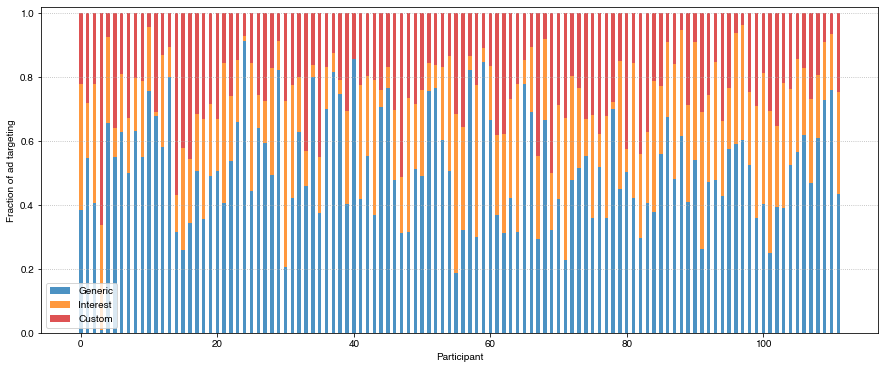

In [10]:
# PLOTTING USER LEVEL STACKED BAR PLOT
custom_total, generic_total, interest_total = 0, 0, 0
f, axs = plt.subplots(1, 1, figsize=(15, 6))
colors = ['tab:blue', 'tab:orange', 'tab:red']
labels = ['Generic', 'Interest', 'Custom']

interest_fracs, custom_fracs, total_fracs = [], [], []
part_ad_counts = pid_adid.groupby('pid').count().to_dict()['adid']
last = np.zeros(len(survey1_pids))
part_order = sorted(survey1_pids, key=lambda pid: part_code_props[pid].get('Benign', 0), reverse=True)
# exclude participants with < 25 ads
part_order = [p for p in part_order if part_ad_counts[p] >= 25]

for i, uid in enumerate(part_order):
    total = pid_adid[pid_adid['pid'] == uid].shape[0]
    interest_targeted = tar_interest(uid)
    custom = tar_custom(uid)
    generic = total - interest_targeted - custom
    interest_total += interest_targeted; custom_total += custom; generic_total += generic
    
    # convert to fractions
    interest_targeted /= total; custom /= total; generic /= total    
    
#     err = [normal_bin_conf(curr[i], totals[p]) if (totals[p]*curr[i]) >= 5 else 0 \
#         for i, p in enumerate(hor_order)]
    last = 0
    for j, frac in enumerate([generic, interest_targeted, custom]):
        err = normal_bin_conf(frac, total)
        err = None
        axs.bar([i], [frac], .5, bottom=last, ecolor=colors[j],
                  color=colors[j], alpha=.8, yerr=err, label=labels[j])
        labels[j] = ''
        last += frac
        
axs.legend()
axs.set_ylim(top=1.02)
axs.grid(ls=':', axis='y')
axs.set_ylabel('Fraction of ad targeting')
axs.set_xlabel('Participant')

# plt.savefig('targeting-differences-user.jpg', dpi=200, bbox_inches='tight')

### Targeting Differences by Code

In [11]:
# unpack by code
code_ads = find_code_ads(dict(codes[['adid', 'codes']].values))

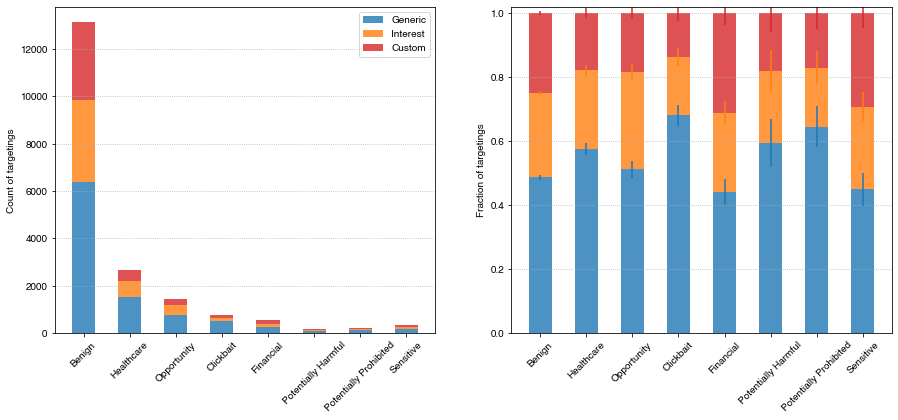

In [12]:
plot_codes = ['Benign', 'Healthcare', 'Opportunity', 'Clickbait', 'Financial',
              'Potentially Harmful', 'Potentially Prohibited', 'Sensitive']
f, axs = plt.subplots(1, 2, figsize=(15, 6))

labels = ['Generic', 'Interest', 'Custom']
for i, c in enumerate(plot_codes):    
    n_interest, n_custom, n_generic = 0, 0, 0
#     if c == 'Harmful':
#         total = len(code_ads['Potentially Prohibited']) + len(code_ads['Potentially Harmful'])
#         curr_code_ads = code_ads['Potentially Prohibited'] + code_ads['Potentially Harmful']
#     else:
    total = len(code_ads[c])
    curr_code_ads = code_ads[c]        
        
    for aid in curr_code_ads:
        # preprocess targeting json
        tar = get_targeting(ad_targetings[str(aid)], aid)
        if 'interests' in tar:
            n_interest += 1
        if 'custom' in tar:
            n_custom += 1

    n_generic = total - n_interest - n_custom
            
    # counts on left plot
    last = 0
    for j, count in enumerate([n_generic, n_interest, n_custom]):
        axs[0].bar([i], [count], .5, bottom=last, ecolor=colors[j],
                  color=colors[j], alpha=.8, yerr=err, label=labels[j])
        labels[j] = ''
        last += count

    # fractions on right plot
    last = 0
    for j, frac in enumerate([n_generic/total, n_interest/total, n_custom/total]):
        err = normal_bin_conf(frac, total)
        axs[1].bar([i], [frac], .5, bottom=last, ecolor=colors[j],
                  color=colors[j], alpha=.8, yerr=err)
        
        last += frac
      
axs[0].legend()
axs[0].set_ylabel('Count of targetings')
axs[1].set_ylabel('Fraction of targetings')
axs[1].set_ylim(top=1.02)
for ax in axs:
    ax.grid(ls=':', axis='y')
    ax.set_xticks(range(len(plot_codes)))
    ax.set_xticklabels(plot_codes, rotation=45)
    
# plt.savefig('targeting-differences-code-2.jpg', dpi=200, bbox_inches='tight')

In [24]:
codes[codes['codes'].str.contains('Potentially Harmful')]
# .iloc[:20]

,adid,codes
3206,6275513875993,Potentially Harmful;Sensitive
3417,23847356524530423,Clickbait;Potentially Harmful
3551,23848503752320581,Potentially Harmful
3750,23848723144570407,Clickbait;Potentially Harmful
5054,23849772514710031,Clickbait;Potentially Harmful
...,...,...
18288,23849914265270272,Clickbait;Potentially Harmful
18425,23850095311930681,Clickbait;Opportunity;Potentially Harmful
18535,23850342785410369,Healthcare;Potentially Harmful
18545,23850377862010090,Clickbait;Potentially Harmful
